In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime
from datetime import date,timedelta
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import seaborn as sns
import pandas_ta as ta
import numpy as np
import json
from tkinter import *
from tkinter import messagebox, ttk, END
from matplotlib import dates

/opt/anaconda3/envs/DataScience/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
today = date.today()

d1 = today.strftime('%Y-%m-%d')
end_date = d1
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime('%Y-%m-%d')
start_date = d2

In [3]:
ticker = input('Write ticker: ')
stock_data = yf.download(ticker, start = start_date, end = end_date, progress=False, auto_adjust=False)
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = stock_data.columns.droplevel(1)
stock_data


1 Failed download:
['XRP-USD']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,


In [4]:
#RSI, Garman, ATR, MACD
stock_data['RSI'] = ta.rsi(close = stock_data["Adj Close"], length=14)

stock_data['Garman'] = ((np.log(stock_data['High'])- np.log(stock_data['Low']))**2)/2-(2*np.log(2)-1)*((np.log(stock_data['Adj Close']) -np.log(stock_data['Open']))**2)

def compute_atr(stock_data):
    atr = ta.atr(high=stock_data['High'], low=stock_data['Low'], close=stock_data['Close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())
stock_data['ATR'] = compute_atr(stock_data)

def compute_macd(stock_data, short_period=12, long_period=26, signal_period=9):
    # Compute MACD, Signal Line, and Histogram using pandas_ta
    macd = ta.macd(
        close=stock_data['Close'], 
        fast=short_period, 
        slow=long_period, 
        signal=signal_period
    )
    
    # Assign the results to new columns in the DataFrame
    stock_data['MACD'] = macd['MACD_12_26_9']  # Default naming format
    stock_data['Signal'] = macd['MACDs_12_26_9']
    stock_data['MACD_Histogram'] = macd['MACDh_12_26_9']
    
    return stock_data

# Apply the function to compute MACD
stock_data = compute_macd(stock_data)

today = date.today() 
two_weeks = today - timedelta(days=14)

#Last 14 days
technical_analysis = stock_data.iloc[-14:]
technical_analysis

AttributeError: 'NoneType' object has no attribute 'sub'

In [ ]:
#Price chart
fig = go.Figure(data=[go.Scatter(x=stock_data.index, y=stock_data['Adj Close'], mode='lines', name='Adj Close')])
fig.update_layout(
    xaxis_rangeslider_visible=False,
    yaxis_title=f'{ticker} Price',
    xaxis_title='Date',
    plot_bgcolor='lightgrey',
    width=1050,
    height=600
)
fig.show()

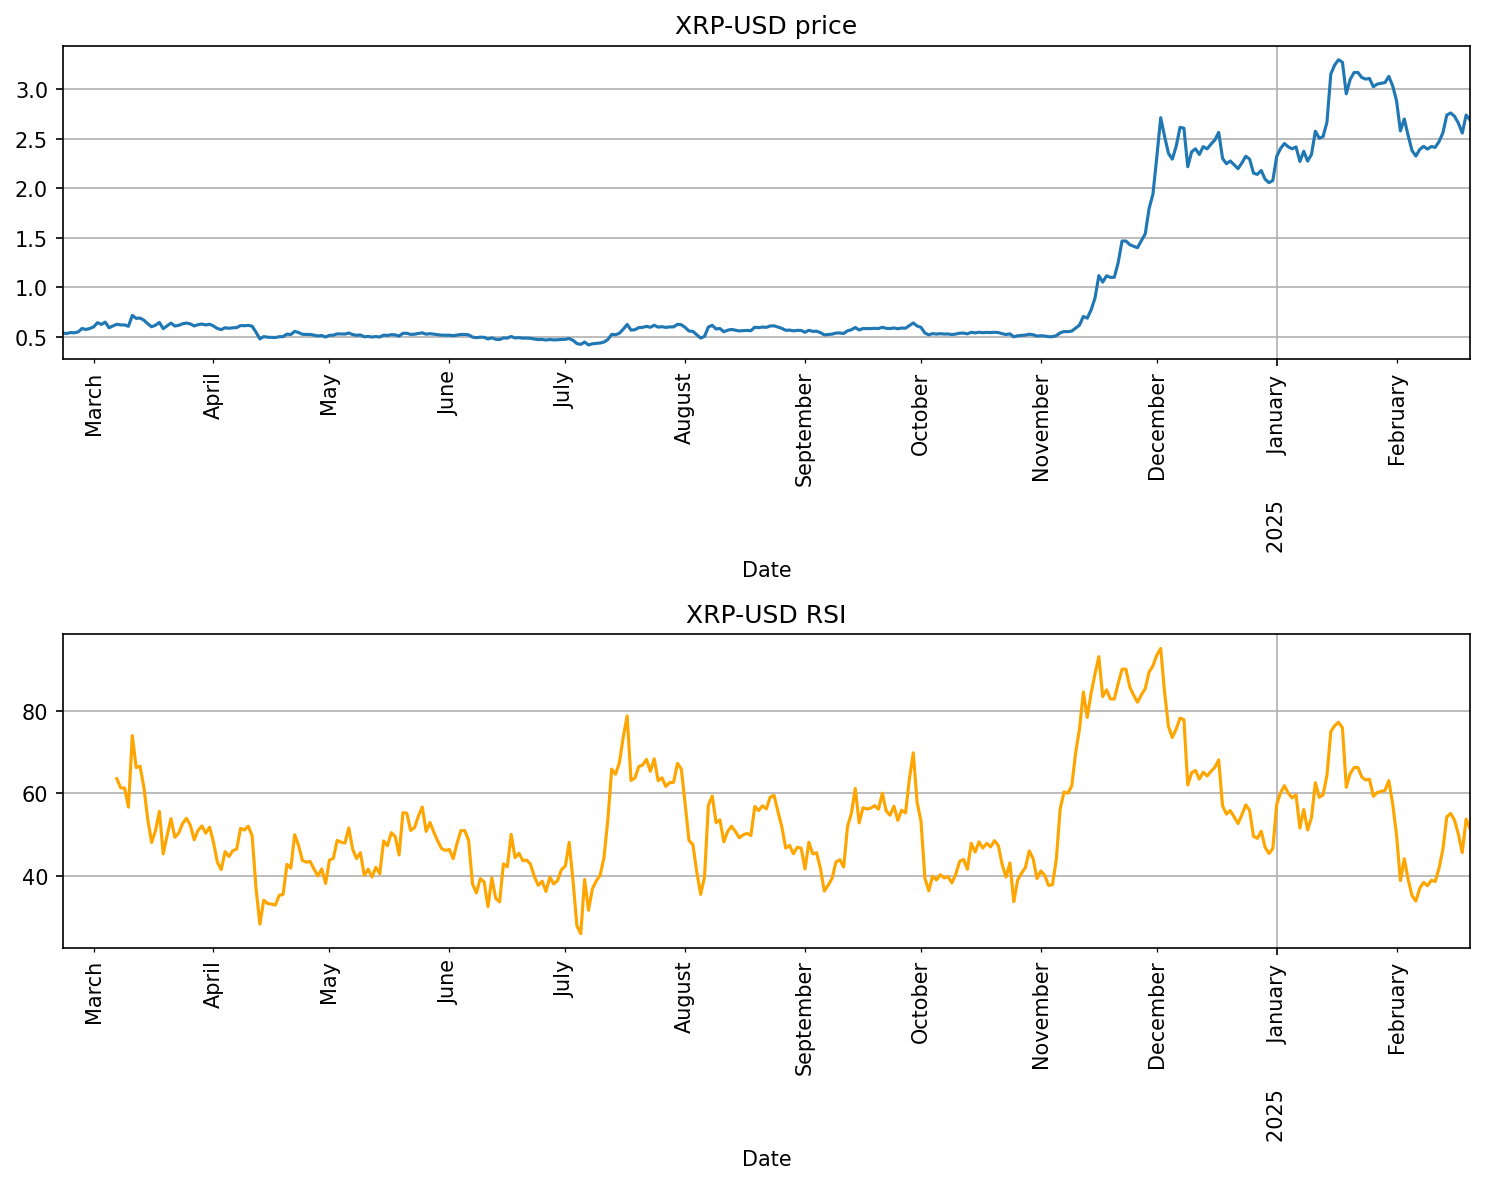

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), dpi=150)
stock_data['Adj Close'].plot(ax=ax[0])
ax[0].set_title(f'{ticker} price')
ax[0].xaxis.set_major_locator(dates.YearLocator())
ax[0].xaxis.set_major_formatter(dates.DateFormatter('%Y       %B'))
ax[0].tick_params(axis='x', which = 'major', rotation = 90)
ax[0].xaxis.set_minor_locator(dates.MonthLocator())
ax[0].xaxis.set_minor_formatter(dates.DateFormatter('%B'))
ax[0].tick_params(axis='x', which = 'minor', rotation = 90)

ax[0].xaxis.grid()
ax[0].yaxis.grid()

#Voltality
stock_data['RSI'].plot(ax=ax[1], c='orange')
ax[1].set_title(f'{ticker} RSI')
ax[1].xaxis.set_major_locator(dates.YearLocator())
ax[1].xaxis.set_major_formatter(dates.DateFormatter('%Y       %B'))
ax[1].tick_params(axis='x', which = 'major', rotation = 90)
ax[1].xaxis.set_minor_locator(dates.MonthLocator())
ax[1].xaxis.set_minor_formatter(dates.DateFormatter('%B'))
ax[1].tick_params(axis='x', which = 'minor', rotation = 90)

ax[1].xaxis.grid()
ax[1].yaxis.grid()

plt.tight_layout()
plt.show()

In [ ]:
#Candlestick
fig = go.Figure(data=[go.Candlestick(x=stock_data.index, open = stock_data['Open'], close=stock_data['Close'], high = stock_data['High'], low=stock_data['Low'])])
fig.update_layout(xaxis_rangeslider_visible=False, yaxis_title=f'{ticker} stock', xaxis_title='Date', plot_bgcolor='lightgrey',
                  width=1050, height = 600)
fig.show()

In [ ]:
#RSI
fig = go.Figure(data=[go.Scatter(x=stock_data.index, y=stock_data['RSI'], mode='lines', name='RSI')])
fig.update_layout(
    xaxis_rangeslider_visible=False,
    yaxis_title=f'{ticker} RSI',
    xaxis_title='Date',
    plot_bgcolor='lightgrey',
    width=1050,
    height=600
)
fig.show()

In [ ]:
#MACD
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=stock_data.index,
    y=stock_data['MACD'],
    mode='lines',
    name='MACD Line',
    line=dict(color='blue', width=2)
))

fig.add_trace(go.Scatter(
    x=stock_data.index,
    y=stock_data['Signal'],
    mode='lines',
    name='Signal Line',
    line=dict(color='orange', width=2)
))

fig.add_trace(go.Bar(
    x=stock_data.index,
    y=stock_data['MACD_Histogram'],
    name='MACD Histogram',
    marker_color='green',
    opacity=0.5
))

fig.update_layout(
    title=f'{ticker} MACD Analysis',
    xaxis_title='Date',
    yaxis_title=f'{ticker} MACD Value',
    plot_bgcolor='lightgrey',
    xaxis_rangeslider_visible=False,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    ),
    width=1050,
    height=600
)

fig.show()

In [ ]:
#MA
stock_data['M10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['M20'] = stock_data['Close'].rolling(window=20).mean()

#Bolinger Bands
stock_data['SD'] = stock_data['Close'].rolling(window=20).std()
# Calculate the Upper Bollinger Band (UB) and Lower Bollinger Band (LB)
stock_data['UB'] = stock_data['M20'] + 2 * stock_data['SD']
stock_data['LB'] = stock_data['M20'] - 2 * stock_data['SD']

#BB graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['UB'], mode='lines', name='Upper Bollinger Band', visible=True, line=dict(color='red')))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['LB'], fill='tonexty', mode='lines', name='Lower Bollinger Band', visible=True, line=dict(color='green')))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['M20'], mode='lines', name='Middle Bollinger Band', visible=True, line=dict(color='blue')))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Close'], mode='lines', name='Price (Bollinger)', visible=True, line=dict(color='black')))
fig.update_layout(
    xaxis_rangeslider_visible=False,
    yaxis_title=f'{ticker} Bolinger Bands',
    xaxis_title='Date',
    plot_bgcolor='lightgrey',
    width=1050,
    height=600
)
fig.show()

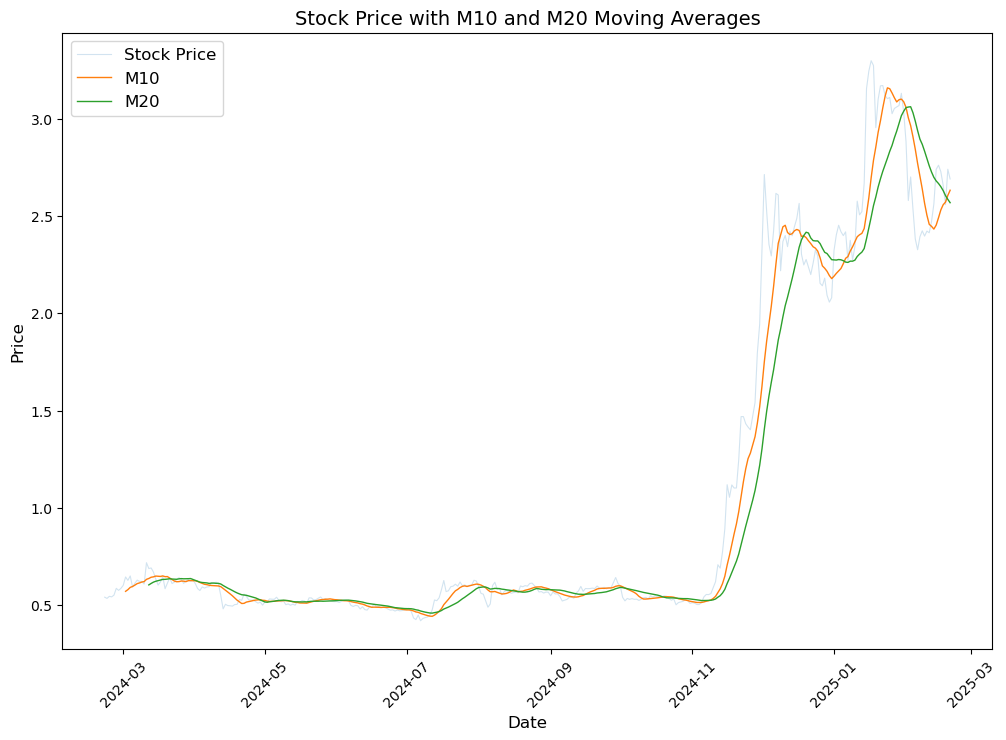

In [ ]:
#MA graph
plt.figure(figsize=(12,8))
plt.plot(stock_data.index, stock_data['Close'], label='Stock Price', linewidth=0.8, alpha=0.2)

plt.plot(stock_data.index, stock_data['M10'], label='M10', linewidth=1, alpha=1)
plt.plot(stock_data.index, stock_data['M20'], label='M20', linewidth=1, alpha=1)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Stock Price with M10 and M20 Moving Averages', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.show()

Sharpe and Sortino Ratio

In [ ]:
columns_to_drop = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'Garman',
       'ATR', 'MACD', 'Signal', 'MACD_Histogram', 'M10', 'M20', 'SD', 'UB',
       'LB',]

stock_data['Daily Returns'] = stock_data['Adj Close'].pct_change(1)
stock_data.drop(columns=columns_to_drop, inplace=True)
stock_data.dropna(inplace=True)

def compute_sharpe_ratio (data,risk_free = 0):
    mean_stock_data = stock_data['Daily Returns'].mean()
    std_stock_data = stock_data['Daily Returns'].std()
    sharpe_ratio = (mean_stock_data-risk_free)/std_stock_data

    return sharpe_ratio

def compute_sortino_ratio (data, threshold = 0, risk_free_rate = 0):
    mean_data = data['Daily Returns'].mean()
    #Always lower values than treshold
    downside = data[data['Daily Returns']<threshold]['Daily Returns']
    std = downside.std()
    sortino_ratio = (mean_data - risk_free_rate)/std

    return sortino_ratio * (365**0.5)

stock_sharpe_ratio = compute_sharpe_ratio(stock_data)
stock_annual_sharpe_ratio = compute_sharpe_ratio(stock_data) * np.sqrt(365)
stock_sortino_ratio = compute_sortino_ratio(stock_data)

print(f'Sharpe Ratio for {ticker} is: {stock_sharpe_ratio}')
print(f'Annual Sharpe ratio for {ticker} is: {stock_annual_sharpe_ratio}')
print(f'Sortino Ratio for {ticker} is: {stock_sortino_ratio}')

Sharpe Ratio for XRP-USD is: 0.11687918973043125
Annual Sharpe ratio for XRP-USD is: 2.232973784462187
Sortino Ratio for XRP-USD is: 3.940508609551333


In [ ]:
#Monte Carlo
xrp = yf.download('XRP-USD', start = start_date, end = end_date, progress=False, auto_adjust=False)
btc = yf.download('BTC-USD', start = start_date, end = end_date, progress=False, auto_adjust=False)
eth = yf.download('ETH-USD', start = start_date, end = end_date, progress=False, auto_adjust=False)

if isinstance(xrp.columns, pd.MultiIndex):
    xrp.columns = xrp.columns.droplevel(1)
if isinstance(btc.columns, pd.MultiIndex):
    btc.columns = btc.columns.droplevel(1)
if isinstance(eth.columns, pd.MultiIndex):
    eth.columns = eth.columns.droplevel(1)


xrp = xrp['Adj Close']
btc = btc['Adj Close']
eth = eth['Adj Close']


In [ ]:
stock = pd.concat([xrp, btc, eth], axis=1)
stock.columns = ['XRP', 'BTC', 'ETH']
stock.head()

,XRP,BTC,ETH
Date,,,
2024-02-22,0.540914,51304.972656,2971.007324
2024-02-23,0.534534,50731.949219,2921.658203
2024-02-24,0.545118,51571.101562,2992.385986
2024-02-25,0.542425,51733.238281,3112.697266
2024-02-26,0.551405,54522.402344,3178.993652


<Axes: xlabel='Date'>

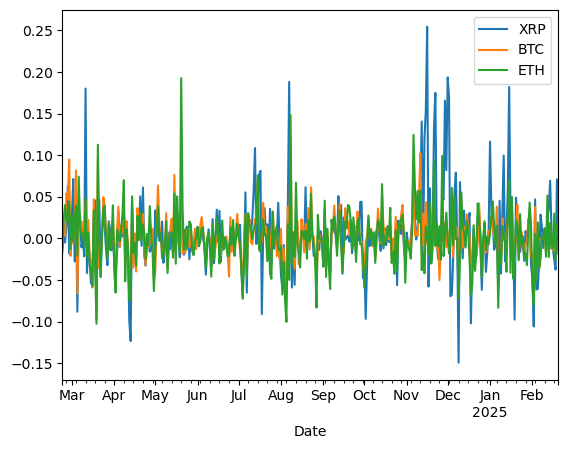

In [ ]:
stock_returns = stock.pct_change(1).dropna()
stock_returns.plot()

In [ ]:
def generate_weights(num_assets):
    weights = np.random.dirichlet(np.ones(num_assets), 1)[0]
    return weights

def calculate_returns(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 365

def calculate_volatility(weights, covariance_matrix):
    annualized_covariance = np.dot(covariance_matrix * 365, weights)
    volatility = np.dot(weights.T, annualized_covariance)
    return np.sqrt(volatility)

def monte_carlo_optimization(log_returns, num_portfolios=50000, num_assets=3):
    best_sharpe = -np.inf
    best_weights = None
    for _ in range(num_portfolios):
        weights = generate_weights(num_assets)
        ret = calculate_returns(weights, log_returns)
        vol = calculate_volatility(weights, log_returns.cov())
        sharpe_ratio = ret / vol
        if sharpe_ratio > best_sharpe:
            best_sharpe = sharpe_ratio
            best_weights = weights
    return best_weights, best_sharpe

def weekly_allocations(tickers, start_date, num_weeks=52):
    end_date = datetime.now()
    historical_data = stock_returns
    weekly_weights = []

    for i in range(num_weeks):
        current_end_date = start_date + timedelta(weeks=i+1)
        current_data = historical_data.loc[:current_end_date]
        log_returns = np.log(current_data / current_data.shift(1)).dropna()
        optimal_weights, sharpe_ratio = monte_carlo_optimization(log_returns)
        weekly_weights.append(optimal_weights)

    return weekly_weights

tickers = ['XRP-USD', 'BTC-USD', 'ETH-USD']
start_date = datetime.now() - timedelta(days=365)
weekly_optimal_weights = weekly_allocations(tickers, start_date)

print(f'{weekly_optimal_weights[-1]}')

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

invalid value encountered in log

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/frame.py:11211: RuntimeWarning:

Degrees of freedom <= 0 for slice

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning:

divide by zero encountered in divide

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning:

invalid value encountered in multiply

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

invalid value encountered in log

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

invalid value encountered in log

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

invalid value encountered in log

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: Ru

[2.51815932e-04 3.37308932e-01 6.62439252e-01]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

tickers = ['XRP-USD', 'BTC-USD', 'ETH-USD']
weekly_optimal_weights_cleaned = []

for stock_weights in weekly_optimal_weights: 
    if stock_weights is None:
        weekly_optimal_weights_cleaned.append([0, 0, 0])
    else:
        weekly_optimal_weights_cleaned.append([float(np.mean(stock)) if isinstance(stock, np.ndarray) else float(stock) for stock in stock_weights])

weekly_optimal_weights_cleaned = np.array(weekly_optimal_weights_cleaned)

scalers = [MinMaxScaler(feature_range=(0, 1)) for _ in range(len(tickers))]

data_scaled = np.column_stack([scalers[i].fit_transform(weekly_optimal_weights_cleaned[:, i].reshape(-1, 1)) for i in range(len(tickers))])

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        Y.append(dataset[i + look_back, :]) 
    return np.array(X), np.array(Y)

look_back = 4
X, Y = create_dataset(data_scaled, look_back)

train_size = int(len(X) * 0.80)
trainX, trainY = X[:train_size], Y[:train_size]
testX, testY = X[train_size:], Y[train_size:]

model = Sequential()
model.add(LSTM(50, input_shape=(look_back, len(tickers)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(tickers)))

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    trainX, trainY,
    epochs=100, batch_size=32,
    validation_data=(testX, testY),
    callbacks=[early_stopping],
    verbose=1
)

trainScore = model.evaluate(trainX, trainY, verbose=0)
testScore = model.evaluate(testX, testY, verbose=0)
print(f'Train Score: {trainScore:.4f} MSE')
print(f'Test Score: {testScore:.4f} MSE')

prediction = model.predict(testX)

prediction_unscaled = np.column_stack([scalers[i].inverse_transform(prediction[:, i].reshape(-1, 1)) for i in range(len(tickers))])

print('Predicted weights for the next period:', prediction_unscaled[-1])

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - loss: 0.2808 - val_loss: 0.2673
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2397
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2220 - val_loss: 0.2122
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1846 - val_loss: 0.1847
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1619 - val_loss: 0.1572
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1286 - val_loss: 0.1307
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1051 - val_loss: 0.1066
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0782 - val_loss: 0.0871
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0537 - val_loss: 0.0758
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0381 - val_loss: 0.0751
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0274 - val_loss: 0.0837
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0354 - val_loss: 0.0931


In [ ]:
def normalize_weights(weights):
    return weights / np.sum(weights)

raw_prediction = np.array(prediction[-1])

normalized_prediction = normalize_weights(raw_prediction).round(3)
print("Normalized Prediction:", normalized_prediction)

Normalized Prediction: [0.115 0.12  0.765]


In [ ]:
print(f'XRP invest should be {250 * normalized_prediction[0]:.2f} dkk')
print(f'BTC invest should be {250 * normalized_prediction[1]:.2f} dkk')
print(f'ETH invest should be {250 * normalized_prediction[2]:.2f} dkk')

XRP invest should be 28.75 dkk
BTC invest should be 30.00 dkk
ETH invest should be 191.25 dkk
